In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from optuna.integration import lightgbm as lgb
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics
from sklearn import model_selection
import lightgbm as lgb

import glob, re
import sys, os
sys.path.append('../../src/') #モジュールが入っているディレクトリのパスを指定

import maprepro as mpre
import maprepro2 as mpre2

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 3)

In [2]:
# 2016 until April 2017 traindata
# 2017最終週 testdata

In [61]:
path='../../input/'
# a = pd.read_csv(f'{path}air_reserve.csv',)
asi = pd.read_csv(f'{path}air_store_info.csv',)
avd = pd.read_csv(f'{path}air_visit_data.csv',)
di = pd.read_csv(f'{path}date_info.csv',)
# a = pd.read_csv(f'{path}hpg_reserve.csv',)
# a = pd.read_csv(f'{path}hpg_store_info.csv',)
sa = pd.read_csv(f'{path}sample_submission.csv',)
# a = pd.read_csv(f'{path}store_id_relation.csv',)


In [62]:
avd.shape,sa.shape,avd.shape[0]+sa.shape[0]

((252108, 3), (32019, 2), 284127)

In [63]:
# air_visit_data
def air_visit_data_maesyori(df):
    df.index = pd.to_datetime(df['visit_date'])
    # 要はデータがない日をNanにしてからfillnaで来店者0にしたいだけ
    # 集約関数を適用する必要があるのでmean()している
    df = df.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').mean()).reset_index()
    df['visit_date'] = df['visit_date'].dt.strftime('%Y-%m-%d')
    df['was_nil'] = df['visitors'].isnull()
    df['visitors'].fillna(0, inplace=True)
    return df
    
avd = air_visit_data_maesyori(avd)


In [64]:
avd

,air_store_id,visit_date,visitors,was_nil
0,air_00a91d42b08b08d9,2016-07-01,35.0,False
1,air_00a91d42b08b08d9,2016-07-02,9.0,False
2,air_00a91d42b08b08d9,2016-07-03,0.0,True
3,air_00a91d42b08b08d9,2016-07-04,20.0,False
4,air_00a91d42b08b08d9,2016-07-05,25.0,False
...,...,...,...,...
296274,air_fff68b929994bfbd,2017-04-18,6.0,False
296275,air_fff68b929994bfbd,2017-04-19,2.0,False
296276,air_fff68b929994bfbd,2017-04-20,2.0,False
296277,air_fff68b929994bfbd,2017-04-21,4.0,False


In [7]:
# date_info
date_info = pd.read_csv(f'{path}/date_info.csv')
def date_info_maesyori(df):
    df.rename(columns={'calendar_date': 'visit_date','holiday_flg': 'is_holiday'}, inplace=True)
    df['prev_day_is_holiday'] = df['is_holiday'].shift().fillna(0)
    df['next_day_is_holiday'] = df['is_holiday'].shift(-1).fillna(0)
    return df

date_info = date_info_maesyori(date_info)

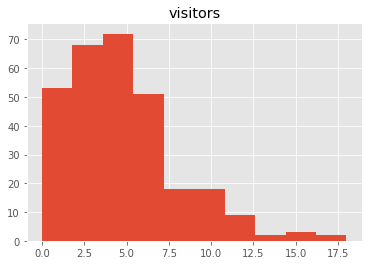

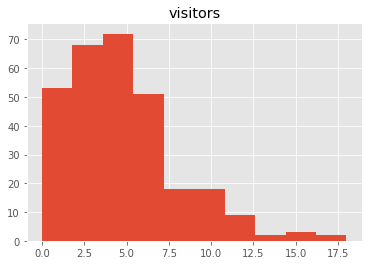

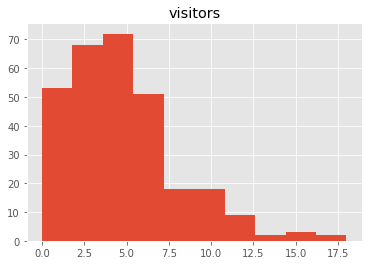

In [8]:
# 店の売り上げは正規標本っていうよりポアソン…?まあ正規標本か…
store_list = pd.unique(avd.air_store_id)
for store in store_list[:3]:
    avd.query('air_store_id=="air_fff68b929994bfbd"').hist()

In [9]:
def find_outliers(series):
    # True,falseが返る
    # 2.4は恣意的なのでナンセンスかも
    # print(series.mean())
    return (series - series.mean()) / series.std() > 2.4

def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series

def is_outlier_and_transformation_to_clipped_value(avd):
    stores = avd.groupby('air_store_id')
    avd['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values
    avd['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
    return avd
avd = is_outlier_and_transformation_to_clipped_value(avd)


In [10]:
def transformation_of_sample_submission(sa):
    # sample_submissionファイルを前処理
    # store_idとvisit_dateに分割
    # テストのフラグを立てる
    # 目的変数をnanに
    # 連番を降る
    sa['air_store_id'] = sa['id'].str.slice(0, 20)
    sa['visit_date'] = sa['id'].str.slice(21)
    sa['is_test'] = True
    sa['visitors'] = np.nan
    sa['test_number'] = range(len(sa))
    return sa
sa = transformation_of_sample_submission(sa)

In [11]:
'''air_visit+sample_submission+date_info+air_store_info'''
def all_integration():
    '''今まで作成した特徴量を１つのデータフレームに統合'''
    data = pd.concat((avd, sa.drop('id', axis='columns')))
    data['is_test'].fillna(False, inplace=True)
    data = pd.merge(data, date_info, how='left', left_on=['visit_date'], right_on=['visit_date'])
    data = pd.merge(left=data, right=asi, on='air_store_id', how='left')
    return data
data = all_integration()

In [12]:
def transformation_of_data(data):
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data.index = data['visit_date']
    # astypeでtrue,false→1,0に変換できる
    data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
    data['day_of_month'] = data['visit_date'].dt.day
    # data['day_of_week'] = data['visit_date'].dt.dayofweek
    data['visitors_capped_log1p'] = np.log1p(data['visitors_capped'])
    
    data = pd.get_dummies(data, columns=['day_of_week','air_genre_name'])
    return data

data = transformation_of_data(data)

In [13]:
data.is_test.sum()

32019

In [14]:
# train = data[(data['is_test'] == False)]
# こっちにすると損失がかなーり減る
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_nil'] == False)]


test = data[data['is_test']].sort_values('test_number')

drop_list = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
           'is_outlier', 'visitors', 'visitors_capped', 'air_area_name']
# to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
#            'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
#            'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
#            'station_great_circle']

train = train.drop(drop_list, axis='columns')
y = train['visitors_capped_log1p']
train = train.drop('visitors_capped_log1p', axis='columns')
test = test.drop(drop_list, axis='columns')
test = test.drop('visitors_capped_log1p', axis='columns')


In [15]:
train.shape,y.shape,test.shape

((247224, 28), (247224,), (32019, 28))

In [16]:
train.isnull().sum().sum()

0

In [17]:
train.describe()
y.describe()

count    247224.000
mean          2.782
std           0.798
min           0.693
25%           2.303
50%           2.890
75%           3.367
max           5.118
Name: visitors_capped_log1p, dtype: float64

In [51]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(train, y)
# print("Result on validation data: ", clf.evaluate(X_val, y_val))
from sklearn.metrics import mean_squared_error as mse
mse(y,lr.predict(train))


0.58187319061022

In [69]:
# X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.25)
feature_importances = pd.DataFrame(index=train.columns)
test_preds = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(train, y)):
    print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
    print(train_idx.shape, test_idx.shape)
        
    X_train, X_valid = train.iloc[train_idx], train.iloc[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    lgbm_params = {
            "objective": "regression",
            "learning_rate": 0.1,
            "boosting_type": "gbdt",
            # "min_data_in_leaf":600,
            # "max_bin": 196,
            # "feature_fraction":0.4,
            # "lambda_l1":36, "lambda_l2":80,
            # "max_depth":10,
            # "num_leaves":1000,
            # "metric": "mae",
            'metric': 'rmse',
            'verbose': 1,
            "tree_learner": "voting",
            "n_jobs": 9,
            "seed": 71
        }

    model = lgb.train(
        lgbm_params, lgb_train,
        valid_sets=[lgb_train,lgb_eval],
        valid_names=['train', 'valid'],
        verbose_eval=100,
        num_boost_round=10000,
        early_stopping_rounds=1000,
    )
    test_pred = model.predict(test)
    test_preds.append(test_pred)
    
    y_pred = model.predict(X_valid)
    score = mse(y_valid, y_pred)
    score = np.expm1(mse(y_valid, y_pred))
    print(f"Fold-{fold+1} | OOF Score: {score}")

# val_mean = np.mean(val_scores)
# val_std = np.std(val_scores)

# print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))


--------------- > Fold 1 < ---------------
(197779,) (49445,)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 197779, number of used features: 28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.781636
Training until validation scores don't improve for 1000 rounds
[100]	train's rmse: 0.696083	valid's rmse: 0.697957
[200]	train's rmse: 0.685367	valid's rmse: 0.689262
[300]	train's rmse: 0.680215	valid's rmse: 0.686398
[400]	train's rmse: 0.677115	valid's rmse: 0.685934
[500]	train's rmse: 0.674559	valid's rmse: 0.686036
[600]	train's rmse: 0.672411	valid's rmse: 0.686106
[700]	train's rmse: 0.670722	valid's rmse: 0.686685
[800]	train's rmse: 0.669252	valid's rmse: 0.687254
[900]	train's rmse: 0.667861	val

C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score 2.780571
Training until validation scores don't improve for 1000 rounds
[100]	train's rmse: 0.69636	valid's rmse: 0.700228
[200]	train's rmse: 0.685447	valid's rmse: 0.691932
[300]	train's rmse: 0.679898	valid's rmse: 0.688725
[400]	train's rmse: 0.676535	valid's rmse: 0.687718
[500]	train's rmse: 0.674096	valid's rmse: 0.687741
[600]	train's rmse: 0.672121	valid's rmse: 0.688059
[700]	train's rmse: 0.670347	valid's rmse: 0.688648
[800]	train's rmse: 0.668799	valid's rmse: 0.689214
[900]	train's rmse: 0.667386	valid's rmse: 0.689647
[1000]	train's rmse: 0.666199	valid's rmse: 0.690222
[1100]	train's rmse: 0.665076	valid's rmse: 0.690711
[1200]	train's rmse: 0.663816	valid's rmse: 0.691472
[1300]	train's rmse: 0.662687	valid's rmse: 0.692013
[1400]	train's rmse: 0.661614	valid's rmse: 0.692615
Early stopping, best iteration is:
[438]	train's rmse: 0.675507	valid's rmse: 0.687582
Fold-2 | OOF Score: 0.6044298307985272
--------------- > Fold 3 <

C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 197779, number of used features: 28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.782437
Training until validation scores don't improve for 1000 rounds
[100]	train's rmse: 0.695555	valid's rmse: 0.700183
[200]	train's rmse: 0.684669	valid's rmse: 0.69219
[300]	train's rmse: 0.67955	valid's rmse: 0.689573
[400]	train's rmse: 0.67619	valid's rmse: 0.688836
[500]	train's rmse: 0.673772	valid's rmse: 0.68869
[600]	train's rmse: 0.671705	valid's rmse: 0.688847
[700]	train's rmse: 0.669777	valid's rmse: 0.689278
[800]	train's rmse: 0.6683	valid's rmse: 0.689864
[900]	train's rmse: 0.666885	valid's rmse: 0.690585
[1000]	train's rmse: 0.665567	valid's rmse: 0.691108
[1100]	train's rmse: 0.664225	valid's rmse: 0.691746
[1200]	train's rmse: 0.663131	valid's rmse: 0.692286
[1300]	train's rmse: 0.662079	valid's rmse: 0.692903
[14

C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	train's rmse: 0.697315	valid's rmse: 0.694952
[200]	train's rmse: 0.687008	valid's rmse: 0.686802
[300]	train's rmse: 0.681885	valid's rmse: 0.684033
[400]	train's rmse: 0.678456	valid's rmse: 0.683027
[500]	train's rmse: 0.675742	valid's rmse: 0.682499
[600]	train's rmse: 0.673759	valid's rmse: 0.682739
[700]	train's rmse: 0.672067	valid's rmse: 0.683033
[800]	train's rmse: 0.670472	valid's rmse: 0.683336
[900]	train's rmse: 0.669168	valid's rmse: 0.683859
[1000]	train's rmse: 0.668003	valid's rmse: 0.684491
[1100]	train's rmse: 0.666689	valid's rmse: 0.685113
[1200]	train's rmse: 0.665532	valid's rmse: 0.685747
[1300]	train's rmse: 0.664444	valid's rmse: 0.686501
[1400]	train's rmse: 0.663512	valid's rmse: 0.687074
Early stopping, best iteration is:
[487]	train's rmse: 0.676071	valid's rmse: 0.68245
Fold-4 | OOF Score: 0.5931887805562399
--------------- > Fold 5 < ---------------
(197780,) (49444,)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	train's rmse: 0.696454	valid's rmse: 0.700423
[200]	train's rmse: 0.685197	valid's rmse: 0.691867
[300]	train's rmse: 0.680508	valid's rmse: 0.689841
[400]	train's rmse: 0.676892	valid's rmse: 0.688689
[500]	train's rmse: 0.674238	valid's rmse: 0.688389
[600]	train's rmse: 0.672059	valid's rmse: 0.688421
[700]	train's rmse: 0.670271	valid's rmse: 0.68877
[800]	train's rmse: 0.668627	valid's rmse: 0.689262
[900]	train's rmse: 0.667157	valid's rmse: 0.689696
[1000]	train's rmse: 0.665833	valid's rmse: 0.690328
[1100]	train's rmse: 0.664512	valid's rmse: 0.690839
[1200]	train's rmse: 0.663378	valid's rmse: 0.691427
[1300]	train's rmse: 0.66225	valid's rmse: 0.692087
[1400]	train's rmse: 0.661368	valid's rmse: 0.692567
[1500]	train's rmse: 0.660485	valid's rmse: 0.693237
Early stopping, best iteration is:
[515]	train's rmse: 0.673861	valid's rmse: 0.68835
Fold-5 | OOF Score: 0.6061271507523907


In [70]:
sub = sa['id'].to_frame()
sub['visitors'] = 0
sub['visitors'] = sum(test_preds)/5
sub['visitors'] = np.expm1(sub['visitors'])


In [76]:
%matplotlib inline
import shap
shap.initjs()

In [78]:
test = shap.sample(test, 1000)
explainer = shap.TreeExplainer(model, data=test)
# Consider using shap.sample(data, 100) to create a smaller background data set.


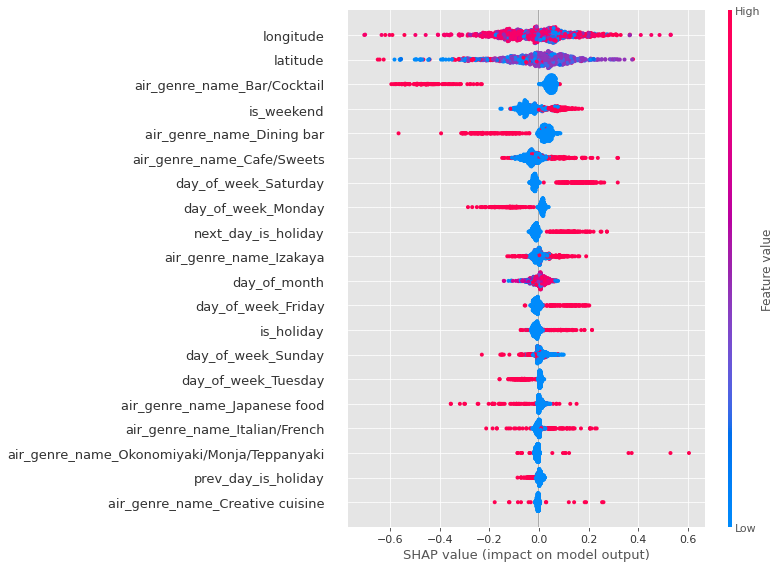

In [81]:
# そして、TreeExplainer を使って、モデルがどのように推論するか解釈したいデータについて SHAP Value を計算しよう。
# この SHAP Value は、入力したのと同じ次元と要素数で得られる。 そして、値が大きいほど推論において影響が大きいと見なすことができる。
tr_x_shap_values = explainer.shap_values(test)
# つまり、行方向に見れば「特定の予測に、それぞれの特徴量がどれくらい寄与したか」と解釈できる。 
# 同様に、列方向に見れば「予測全体で、その特徴量がどれくらい寄与したか」と解釈できる。

# Summary Plot
# このグラフは、デフォルトでは特徴量ごとに SHAP Valueを一軸の散布図として描画する。

shap.summary_plot(shap_values=tr_x_shap_values,
                  features=test,
                  feature_names=test.columns)


In [23]:
NOW = mpre2.mk_now()

In [24]:
# missing_values_table(sub)
sub.to_csv(f'../../output/{NOW}.csv',index=False)
tmp = pd.read_csv(f'../../output/{NOW}.csv')
tmp

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,16.867877
1,air_00a91d42b08b08d9_2017-04-24,17.146119
2,air_00a91d42b08b08d9_2017-04-25,19.159523
3,air_00a91d42b08b08d9_2017-04-26,22.896897
4,air_00a91d42b08b08d9_2017-04-27,22.863047
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,12.106317
32015,air_fff68b929994bfbd_2017-05-28,9.426751
32016,air_fff68b929994bfbd_2017-05-29,5.953320
32017,air_fff68b929994bfbd_2017-05-30,6.671103


In [ ]:
aggregation = {'visitors' : 'median'}
vagg = v.groupby(['air_store_id','dow']).agg(aggregation).reset_index()
vagg

,air_store_id,dow,visitors
0,air_00a91d42b08b08d9,0,19.0
1,air_00a91d42b08b08d9,1,24.5
2,air_00a91d42b08b08d9,2,28.0
3,air_00a91d42b08b08d9,3,30.0
4,air_00a91d42b08b08d9,4,35.5
...,...,...,...
5736,air_fff68b929994bfbd,2,4.0
5737,air_fff68b929994bfbd,3,4.0
5738,air_fff68b929994bfbd,4,5.0
5739,air_fff68b929994bfbd,5,7.0


In [ ]:

# submitのヘッダー情報
missing_values_table(submit)

Your selected dataframe has 2 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
visitors,341,1.1


# 検証コード

<AxesSubplot:ylabel='Frequency'>

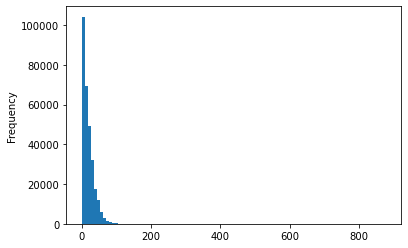

In [ ]:
# 売り上げが正規分布に従っているか検証、１店舗ごとにプロットすると正規分布に従うことがわかる
tmp = air_visit.query("air_store_id == 'air_00a91d42b08b08d9'")
# tmp['visitors'].plot.hist(bins=100)
# air_visit['visitors'].plot.hist(bins=100)

In [ ]:
cv.split(X_train, y_train)

In [ ]:
# hashlib.md5(b"1").digest()
import hashlib
# dat = frozenset(tuner_cv.best_params.items())
# SHA512のハッシュ値
# hs = hashlib.sha1()
hashlib.sha1(str(frozenset(tuner_cv.best_params.items())).encode().hexdigest())
# hs = hashlib.sha224(frozenset(tuner_cv.best_params.items()))
# hs = hashlib.sha224(dat.encode()).hexdigest()
# print(hs)
# dat


In [ ]:
# tuner_cv.best_score
# tuner_cv.best_params
# checkpoint_cb.cv_boosters[4115625917578661725]

len(checkpoint_cb.cv_boosters)
# len(tuner_cv.study.trials)
# checkpoint_cb.get_trained_model(tuner_cv.best_params)
# checkpoint_cb.cv_boosters.keys()
# # tuner_cv.best_params
# cv_booster = checkpoint_cb.get_trained_model(tuner_cv.best_params)
